<a href="https://colab.research.google.com/github/hamagami/pycaret/blob/main/pycaret_mccanom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade

  Cloning https://github.com/pycaret/pycaret.git (to revision master) to /tmp/pip-req-build-cw0tbssn
  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git /tmp/pip-req-build-cw0tbssn
  Resolved https://github.com/pycaret/pycaret.git to commit 58ec3c282d58e94727f9d5b77b49f241e9103ab3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install librosa


Using simulated data.


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

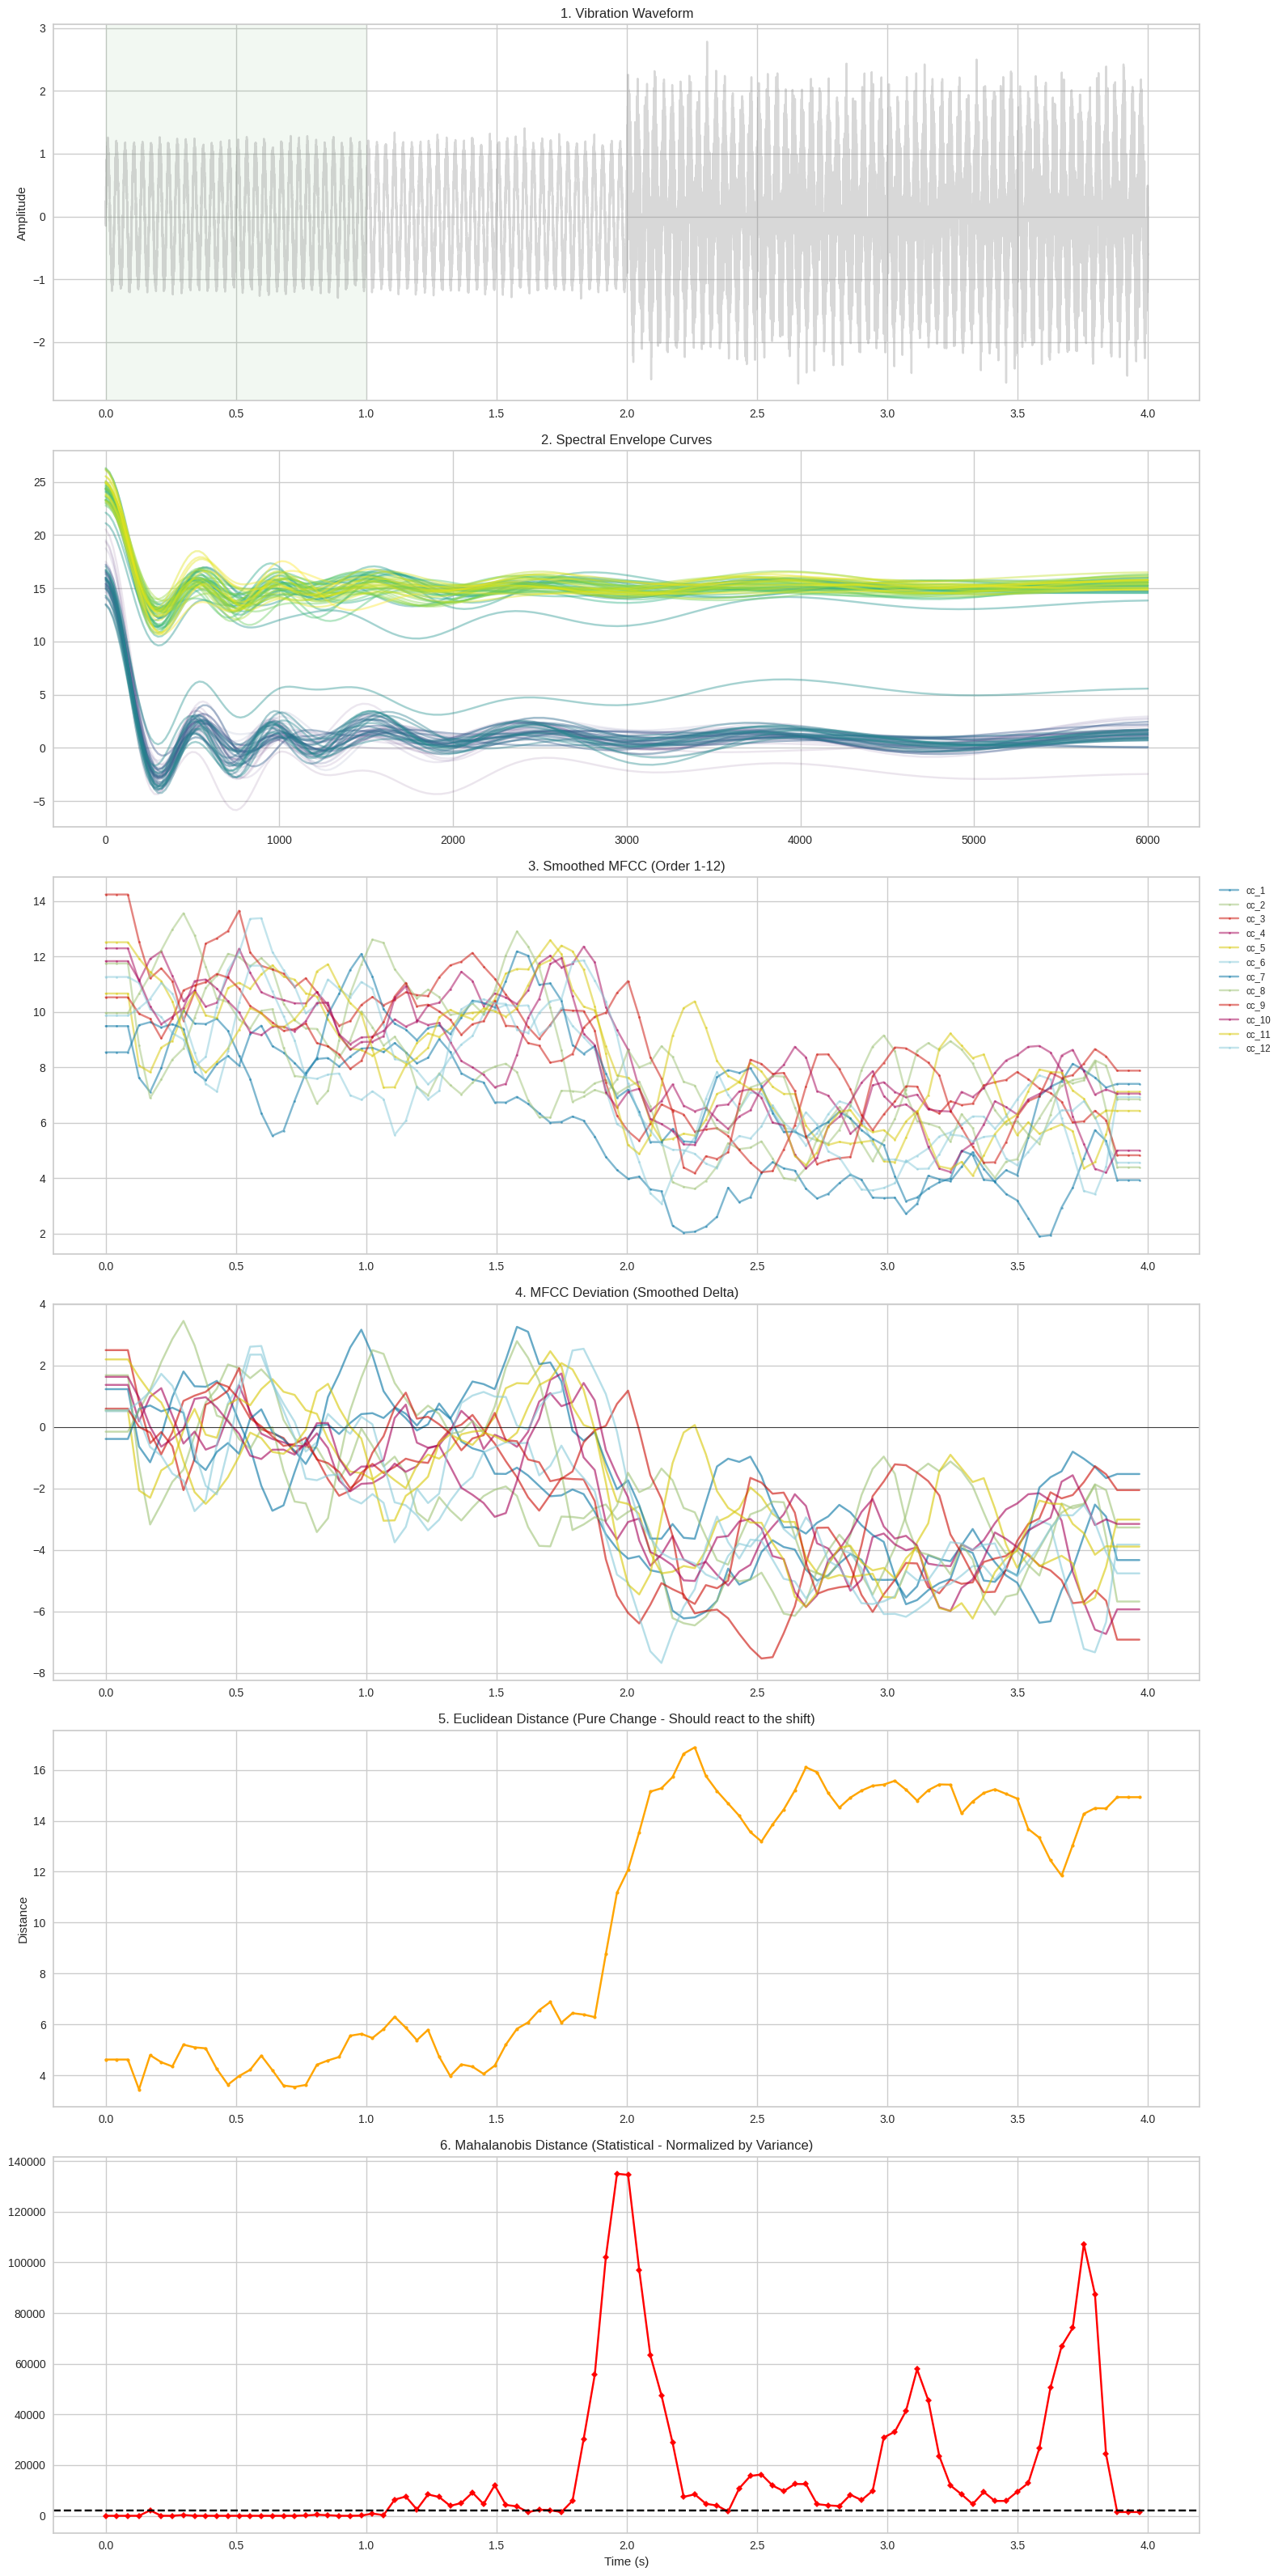

In [21]:
# 1. ライブラリのインストール


import os
import scipy.io
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import urllib.request
from pycaret.anomaly import *

# --- 2. データの取得・生成関数の定義 ---
def generate_vibration_data():
    urls = {
        "normal": "http://csegroups.case.edu/sites/default/files/bearingdata/files/97.mat",
        "fault": "http://csegroups.case.edu/sites/default/files/bearingdata/files/130.mat"
    }
    sr = 12000
    try:
        data_list = []
        for label, url in urls.items():
            filename = f"{label}.mat"
            opener = urllib.request.build_opener(); opener.addheaders = [('User-agent', 'Mozilla/5.0')]
            urllib.request.install_opener(opener); urllib.request.urlretrieve(url, filename)
            mat = scipy.io.loadmat(filename)
            key = [k for k in mat.keys() if "DE_time" in k][0]
            data_list.append(mat[key].flatten()[:24000])
        y = np.concatenate(data_list)
        print("Successfully loaded CWRU data.")
    except:
        print("Using simulated data.")
        t = np.linspace(0, 4, 48000)
        y = np.sin(2 * np.pi * 30 * t) + np.random.normal(0, 0.1, 48000)
        y[24000:] += np.random.normal(0, 0.5, 24000)
    return y, sr

# --- 3. メイン処理 ---
y, sr = generate_vibration_data()

# フレーム分析の設定
n_mfcc = 13
frame_length = 2048 # 平滑化のため少し長めに設定
hop_length = 512

# MFCC抽出
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
df_full = pd.DataFrame(mfccs.T, columns=[f'mfcc_{i}' for i in range(n_mfcc)])

# --- 改良：0次除外と移動平均による平滑化 ---
df_anomaly = df_full.drop(columns=['mfcc_0'])
# 5フレーム分の移動平均をかけてノイズを落とす
df_smooth = df_anomaly.rolling(window=5, center=True).mean().fillna(method='bfill').fillna(method='ffill')

# スペクトル包絡の復元
envelopes_db = librosa.power_to_db(librosa.feature.inverse.mfcc_to_mel(mfccs, n_mels=128))

# 異常検知 (PyCaret) - 学習
frames_in_1s = int(sr / hop_length)
train_df = df_smooth.iloc[:frames_in_1s, :]
s = setup(data=train_df, session_id=123, normalize=True, verbose=False)
mcd_model = create_model('mcd')
results = predict_model(mcd_model, data=df_smooth)

# 偏差とユークリッド距離の計算
normal_mean = train_df.mean()
diff_df = df_smooth - normal_mean
euclidean_dist = np.sqrt((diff_df**2).sum(axis=1))

# --- 4. 可視化 (6段構成) ---
times = librosa.frames_to_time(np.arange(len(results)), sr=sr, hop_length=hop_length)
freqs = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)

fig, axes = plt.subplots(6, 1, figsize=(16, 32))

# (1) 波形
axes[0].plot(np.linspace(0, len(y)/sr, len(y)), y, color='gray', alpha=0.3)
axes[0].axvspan(0, 1, color='green', alpha=0.05, label='Training')
axes[0].set_title("1. Vibration Waveform")
axes[0].set_ylabel("Amplitude")

# (2) スペクトル包絡（重ね書き）
norm = mcolors.Normalize(vmin=0, vmax=times[-1])
cmap = plt.cm.viridis
for i in range(envelopes_db.shape[1]):
    axes[1].plot(freqs, envelopes_db[:, i], color=cmap(norm(times[i])), alpha=0.1 if times[i]<1 else 0.4)
axes[1].set_title("2. Spectral Envelope Curves")

# (3) MFCC推移 (平滑化済)
for i in range(1, n_mfcc):
    axes[2].plot(times, df_smooth[f'mfcc_{i}'], marker='o', markersize=2, alpha=0.5, label=f'cc_{i}')
axes[2].set_title("3. Smoothed MFCC (Order 1-12)")
axes[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='x-small')

# (4) 偏差
for col in diff_df.columns:
    axes[3].plot(times, diff_df[col], alpha=0.6, label=f'diff_{col}')
axes[3].set_title("4. MFCC Deviation (Smoothed Delta)")
axes[3].axhline(y=0, color='black', linewidth=0.5)

# (5) ユークリッド距離 (単純な変化量)
axes[4].plot(times, euclidean_dist, color='orange', marker='o', markersize=3, label='Euclidean')
axes[4].set_title("5. Euclidean Distance (Pure Change - Should react to the shift)")
axes[4].set_ylabel("Distance")

# (6) マハラノビス距離 (統計的距離)
axes[5].plot(times, results['Anomaly_Score'], color='red', marker='D', markersize=4, label='Mahalanobis')
threshold = results['Anomaly_Score'][:frames_in_1s].max()
axes[5].axhline(y=threshold, color='black', linestyle='--', label='Threshold')
axes[5].set_title("6. Mahalanobis Distance (Statistical - Normalized by Variance)")
axes[5].set_xlabel("Time (s)")

for i in [0, 2, 3, 4, 5]: axes[i].sharex(axes[0])
plt.tight_layout()
plt.show()